In [1]:
from reader import get_prices
from matplotlib import pyplot as plt
import pandas as pd
import sklearn
from sklearn.cluster import KMeans
import numpy as np
import pprint

/home/ale/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


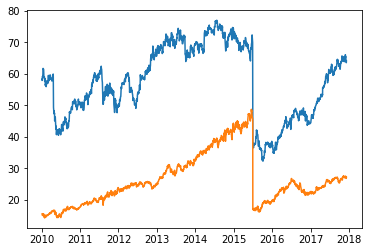

In [2]:
# pandas DataFrame
prices = get_prices()
# list of S&P500 constitutes
symbols = prices.columns
# Apple price
aapl = prices['AAPL']
aapl.head(10)

plt.plot(prices.BAX)
plt.plot(prices.NI)

In [3]:
# CLUSTER COMPANIES TOGETHER BASED ON STOCK TREND

# FEATURE VECTOR USED: 5-DAY PERCENTAGE CHANGE
weekly_priceDiff = {}

symbol_count = 0
for symbol in symbols:
    stock = prices[symbol]
    step = 5
    temp_ls = []

    for a in range(0,len(stock),step):
        stock_diff = 0
        opening_price = stock[a]
        closing_price = None
        try:
            closing_price = stock[a+step-1]
        except:
            closing_price = stock[a+step-2]
        stock_diff = (closing_price - opening_price)/opening_price*100
        temp_ls.append(stock_diff)
        
    weekly_priceDiff[symbol] = temp_ls
       

weekly_priceDiff = pd.DataFrame(weekly_priceDiff)
weekly_priceDiff = weekly_priceDiff.fillna(0)
weekly_priceDiff = weekly_priceDiff.transpose()

In [4]:
weekly_priceDiff.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
A,-1.597444,-1.265412,-4.383117,-0.546262,-1.016949,2.856171,0.718250,3.618316,2.558570,-0.713012,...,2.336449,1.778180,-0.164204,0.684015,0.235398,-2.281703,2.472814,-0.929102,-6.162346,2.354550
AAL,7.756813,9.126984,-7.446809,10.891089,-0.503356,6.832298,4.264706,7.112971,3.212851,-2.141058,...,6.464519,2.631579,-2.258065,-6.382364,-0.420521,-3.435195,3.607346,1.530719,1.442503,3.133212
AAP,0.643883,-2.311133,2.531646,-0.147965,-0.922554,2.549916,-6.203358,2.174988,1.084599,0.403513,...,-4.909274,-8.198112,1.648930,-1.302143,-0.292933,-0.709046,8.495382,-1.706223,12.042223,-0.830450
AAPL,-0.948554,-1.989434,-5.564081,-5.443333,-0.888390,3.675009,-2.710936,4.083606,6.539913,-0.173457,...,0.824033,0.450741,-0.643353,0.800461,3.103343,1.257971,-2.195781,2.417932,-1.889409,-0.159161
ABBV,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.485483,1.027738,6.407853,-6.805411,-0.989884,3.379916,-1.587468,1.944444,-0.209600,0.565978


In [5]:
clusters_no = 200

kmeans = KMeans(n_clusters=clusters_no, random_state=2).fit(weekly_priceDiff)

In [6]:
# len(kmeans.labels_)
# print(kmeans.labels_)

centers = np.zeros(clusters_no)
for i in range(clusters_no):
    centers[kmeans.labels_[i]] += 1
    
# print(centers)
clusters = {}
for cluster in range(clusters_no):
    clusters[cluster] = symbols[np.where(kmeans.labels_==cluster)]
clusters

{0: Index(['WBA'], dtype='object'),
 1: Index(['ETFC'], dtype='object'),
 2: Index(['C'], dtype='object'),
 3: Index(['AIV', 'AVB', 'EQR', 'ESS', 'MAA', 'PSA', 'UDR'], dtype='object'),
 4: Index(['MSI'], dtype='object'),
 5: Index(['BK', 'GS', 'JPM', 'NTRS', 'PBCT', 'RJF', 'SCHW', 'STT'], dtype='object'),
 6: Index(['ARNC'], dtype='object'),
 7: Index(['BCR', 'BDX', 'BSX', 'COO', 'HSIC', 'MDT', 'PDCO', 'SYK', 'VAR', 'XRAY',
        'ZBH'],
       dtype='object'),
 8: Index(['XRX'], dtype='object'),
 9: Index(['COST', 'KR', 'TGT'], dtype='object'),
 10: Index(['AEE', 'AEP', 'AWK', 'CMS', 'CNP', 'DTE', 'DUK', 'ED', 'EIX', 'ES',
        'ETR', 'EXC', 'FE', 'LNT', 'NEE', 'PCG', 'PEG', 'PNW', 'PPL', 'SCG',
        'SO', 'SRE', 'WEC', 'XEL'],
       dtype='object'),
 11: Index(['FLR', 'JEC', 'PWR'], dtype='object'),
 12: Index(['AIZ', 'ALL', 'CB', 'CINF', 'PGR', 'RE', 'XL'], dtype='object'),
 13: Index(['ABBV', 'ALLE', 'ANDV', 'AON', 'APTV', 'AXP', 'BHF', 'BHGE', 'CBOE',
        'CFG', 'COTY

In [7]:
# kmeans.predict([weekly_priceDiff.transpose().AAPL])


# AAPL_cluster = kmeans.predict([weekly_priceDiff.transpose().AAPL])
# for symbol in symbols:
#     if kmeans.predict([weekly_priceDiff.transpose()[symbol]]) == AAPL_cluster:
#         print(symbol)

In [8]:
# RANK CORRELATIONS IN SAME CLUSTER

corr_A = []
corr_B = []
corr_coeff = []
for c in clusters:
    symb = clusters[c]
    if len(symb) > 1:
        values = []
        for s in symb:
            values.append(prices[s].fillna(prices[s].mean()).to_list()) # TO CHECK! filling NaN with mean
        cluster_corr = np.corrcoef(values)
        for i in range(len(symb)):
            for j in range(i+1,len(symb)):
                corr_A.append(symb[i])
                corr_B.append(symb[j])
                corr_coeff.append(cluster_corr[i][j])


d = {}
d["stock_A"] = corr_A
d["stock_B"] = corr_B
d["corr"] = corr_coeff
correlations = pd.DataFrame(data=d)

correlations = correlations.sort_values(["corr"], ascending=[0])
correlations = correlations.reset_index()

In [9]:
correlations.head()

,index,stock_A,stock_B,corr
0,2621,FOX,FOXA,0.997271
1,2431,DISCA,DISCK,0.996414
2,3145,LMT,RTN,0.993594
3,152,AWK,CMS,0.993416
4,220,DTE,NEE,0.992945


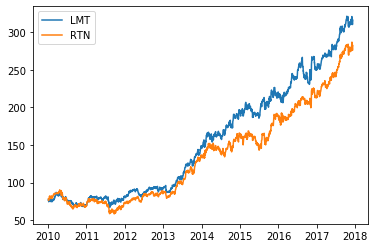

In [14]:
best_corr = correlations.loc[2,:]

plt.plot(prices[best_corr.stock_A], label=best_corr.stock_A)
plt.plot(prices[best_corr.stock_B]*1.5, label=best_corr.stock_B)
plt.legend()